# Stabilization of the advection-diffusion-reaction equation

In [1]:
from lucifex.solver import OptionsPETSc
from lucifex.fdm import AB, CN
from lucifex.sim import run, Simulation
from lucifex.viz import plot_colormap, plot_line
from lucifex.utils import nested_dict
from crocodil.dns import dns_system_a, critical_rayleigh, SYSTEM_A_REFERENCE

STORE = 1
NX = 60
NY = 60

def create_simulation(
    c_stabilization,
    c_limits,
):
    return dns_system_a(
        store_delta=STORE, 
    )(
        Nx=NX,
        Ny=NY,
        scaling='advective',
        **SYSTEM_A_REFERENCE,
        D_adv=AB(1)@CN,
        D_diff=AB(1)@CN,
        dt_max=0.1,
        cfl_courant=0.5,
        c_stabilization=c_stabilization,
        c_limits=c_limits,
        c_petsc=OptionsPETSc('gmres', 'ilu'),
        flow_petsc=(OptionsPETSc('cg', 'hypre'), None),
        diagnostic=True,
    )


stabilization_opts = (
    None,
    10.0,
)
limits_opts = (None, (0, 1))
simulations = nested_dict((float, tuple, Simulation))

for stab in stabilization_opts:
    for lim in limits_opts:
        simulations[stab][lim] = create_simulation(
            stab, lim, 
        )

n_stop = 30
t_stop = 12.0
dt_init = 1e-6
n_init = 10
for stab in stabilization_opts:
    for lim in limits_opts:
        sim = simulations[stab][lim]
        run(sim, n_stop, t_stop, dt_init=dt_init, n_init=n_init)

In [2]:
Ly = 1.0
Lx = SYSTEM_A_REFERENCE['aspect'] * Ly
Ra_crit = critical_rayleigh(Lx, Ly, NX, 2)
print(f"Ra_crit = {Ra_crit}")
print(f"Ra = {SYSTEM_A_REFERENCE['Ra']}")

Ra_crit = 1350.0
Ra = 1000.0


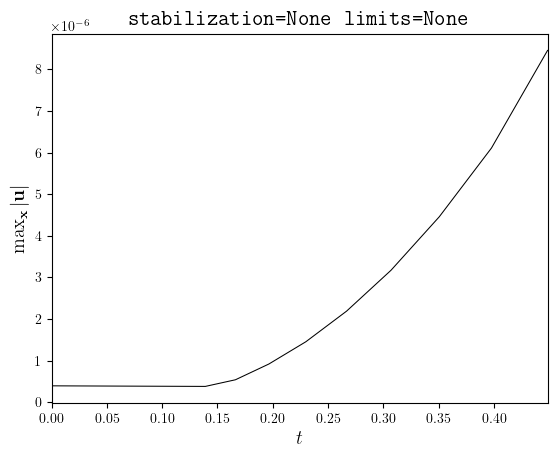

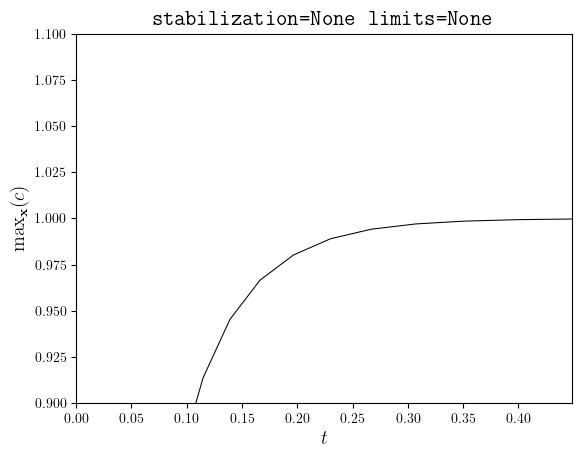

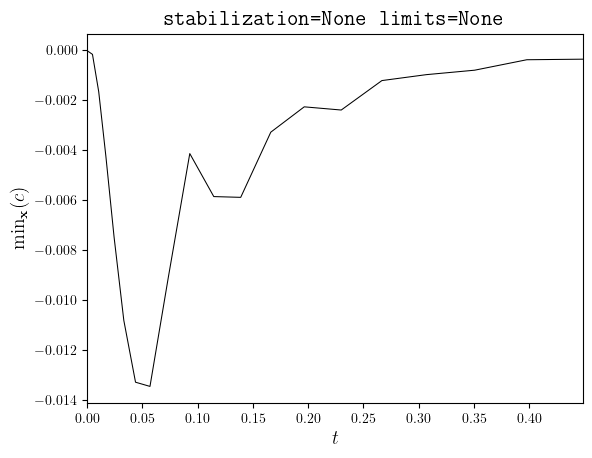

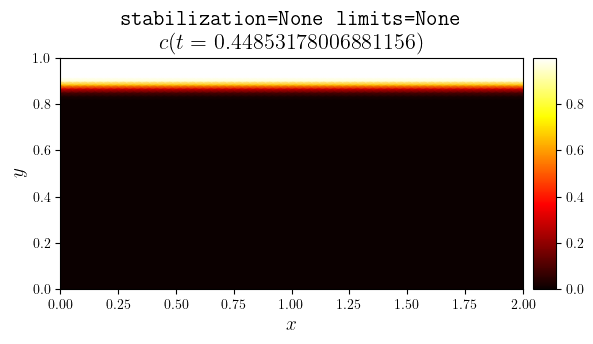

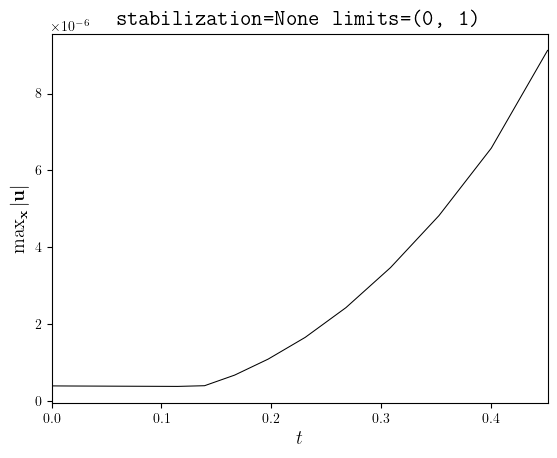

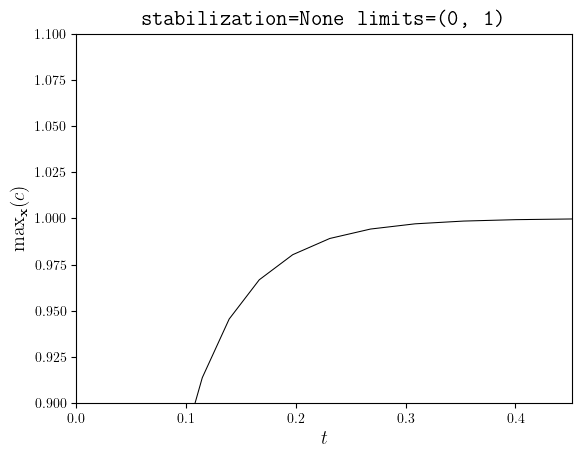

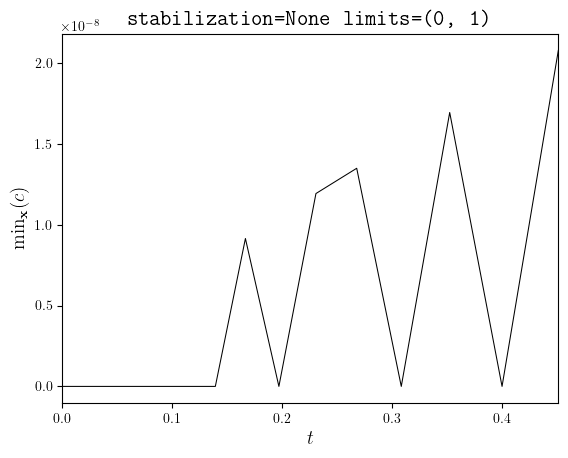

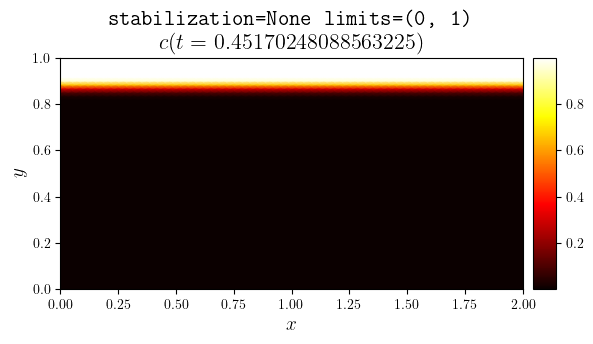

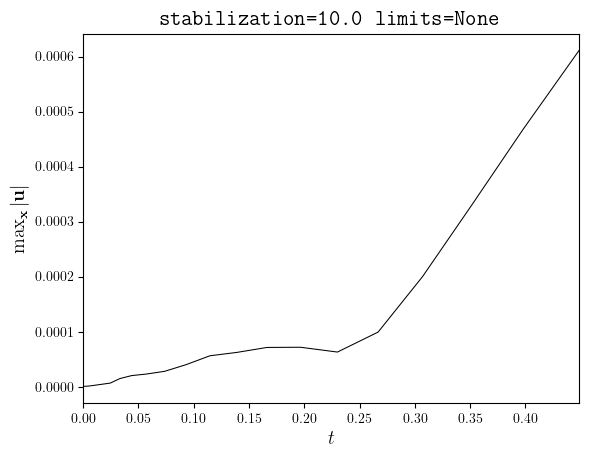

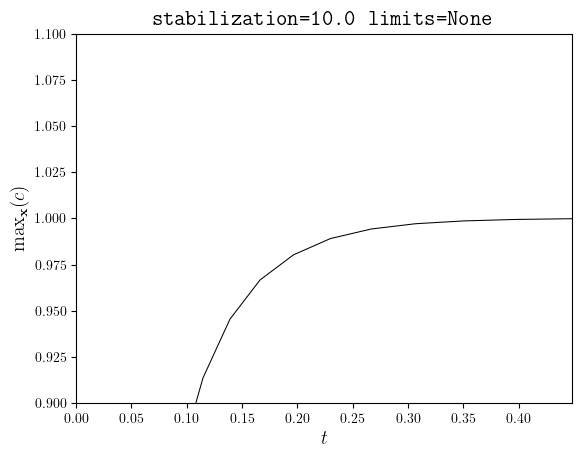

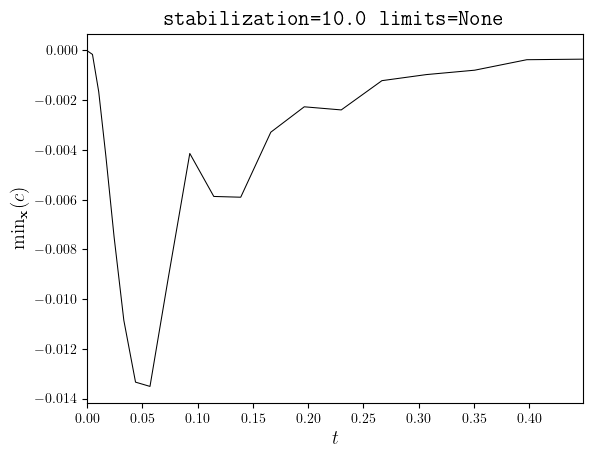

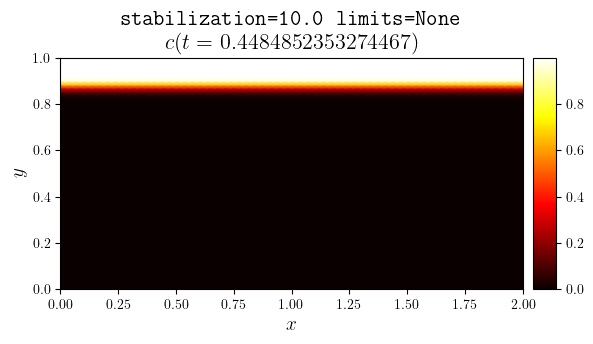

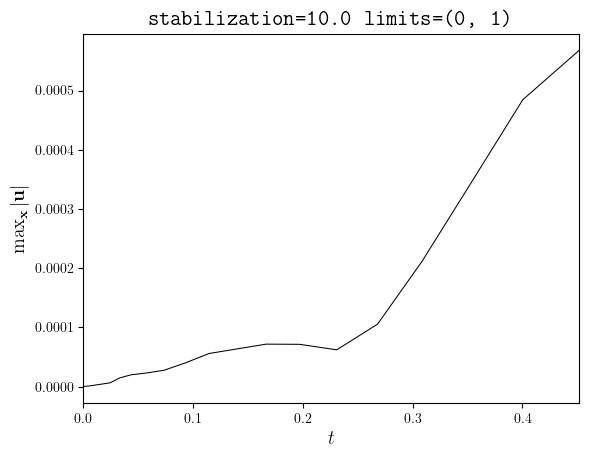

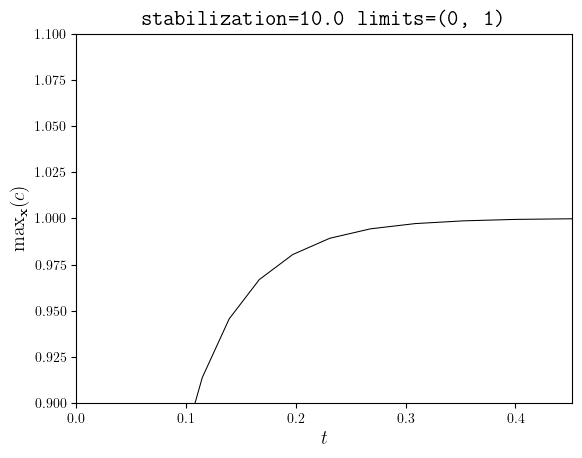

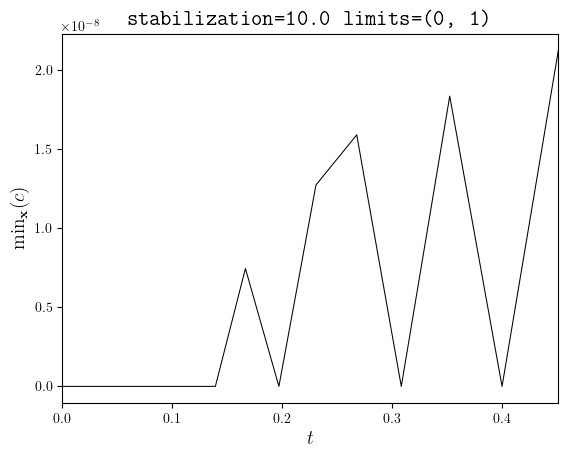

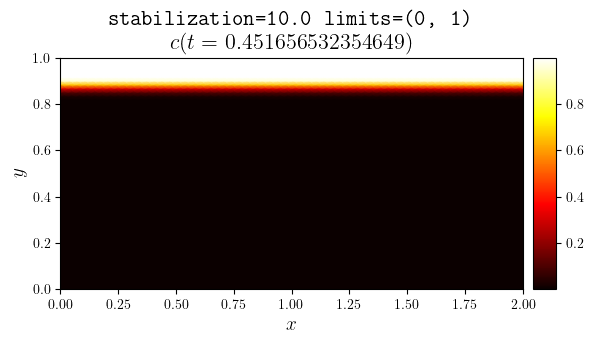

In [3]:
for stab in stabilization_opts:
    for lim in limits_opts:
        title = f'\\texttt{{stabilization={stab} limits={lim}}}'
        sim = simulations[stab][lim]
        uMinMax = sim['uMinMax']
        uMax = uMinMax.sub(1)
        fig, ax = plot_line(
            (uMax.time_series, uMax.value_series),
            x_label='$t$',
            y_label='$\max_{\mathbf{x}}|\mathbf{u}|$',
            title=title,
        )
        cMinMax = sim['cMinMax']
        cMin, cMax = cMinMax.split()
        fig, ax = plot_line(
            (cMax.time_series, cMax.value_series),
            x_label='$t$',
            y_label='$\max_{\mathbf{x}}(c)$',
            y_lims=(1-0.1, 1+0.1),
            title=title,
        )
        fig, ax = plot_line(
            (cMin.time_series, cMin.value_series),
            x_label='$t$',
            y_label='$\min_{\mathbf{x}}(c)$',
            title=title,
        )
        c = sim['c']
        cmap_title = f'{title}\n $c(t={c.time_series[-1]})$'
        fig, ax = plot_colormap(c.series[-1], title=cmap_title)